In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from numpy import nan
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [7]:
# загружаем данные
# координаты домов
points = gpd.read_file('shapes/coordinates/coordinates.shp', encoding='utf-8').set_index('index')
points2 = gpd.read_file('shapes/corr/corr.shp', encoding='utf-8').set_index('idx')
points = points.append(points2, verify_integrity=True)
# данные о домах
data = pd.read_csv('data/housing_data.csv')
data = data.drop(15518)
# карта муниципальных образований
municipalities = gpd.read_file('shapes/municipalities/municipalities.shp', encoding='utf-8')
# сетка
grid = gpd.read_file('shapes/grid500/grid500.shp', encoding='utf-8')
grid = grid.to_crs(epsg=4326)

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


### Расселение
Рассмотрим вопросы расселения:
- плотность (квадратных метров на человека),
- распределение коммунальных квартир по городу.

In [37]:
# отбираем интересующие данные из датасета
population = data[['comm_room_num', 'flat_room_num', 'data_livingarea','data_residents']]
population = gpd.GeoDataFrame(population.join(points), geometry='geometry', crs={'init': 'epsg:4326'})

In [38]:
# преобразуем данные
# суммируем число коммунальных комнат
comm_room_sum = population['comm_room_num'].dropna().apply(lambda x: sum([int(xx) for xx in str(x).split(', ')]))
comm_room_sum.name = 'comm_room_sum'
population = population.join(comm_room_sum, how='left')
# суммируем число индивидуальных комнат
flat_room_sum = population['flat_room_num'].dropna().apply(lambda x: sum([int(xx) for xx in str(x).split(', ')]))
flat_room_sum.name = 'flat_room_sum'
# удаляем старые колонки со списками численности комнат
population = population.drop(['comm_room_num','flat_room_num'], axis=1)
population = population.join(flat_room_sum, how='left')

In [ ]:
# делаем spatial join: муниципальные образования + дома
population = gpd.sjoin(municipalities, population, op='contains')

__Жилая площадь на жильца__

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


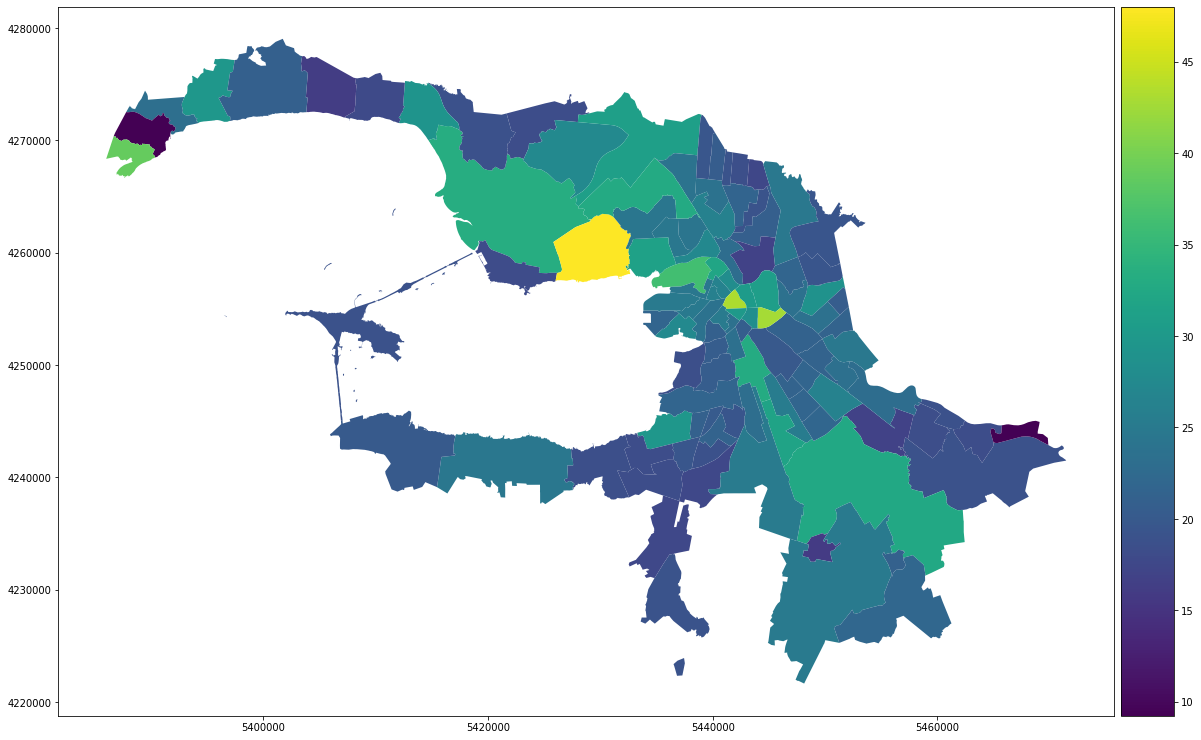

In [16]:
# группируем по муницпалитету
pop_sum = population.groupby('name').sum()
# рассчитываем интересующий параметр
pop_sum['density'] = pop_sum['data_livingarea'] / pop_sum['data_residents']
# аггрегированный датафрейм перестал быть геодатафреймом: джойним его с картой муниципалитетов
pop_sum = municipalities.join(pop_sum, on='name')
pop_sum = gpd.GeoDataFrame(pop_sum, geometry='geometry', crs={'init': 'epsg:4326'})
pop_sum = pop_sum.to_crs(epsg=3035)
# выводим карту, регулируем размер легенды
fig, ax = plt.subplots(1, 1, figsize=(20, 30))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
pop_sum.plot(column='density', ax=ax, legend=True, cax=cax)

__Число коммунальных комнат__

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


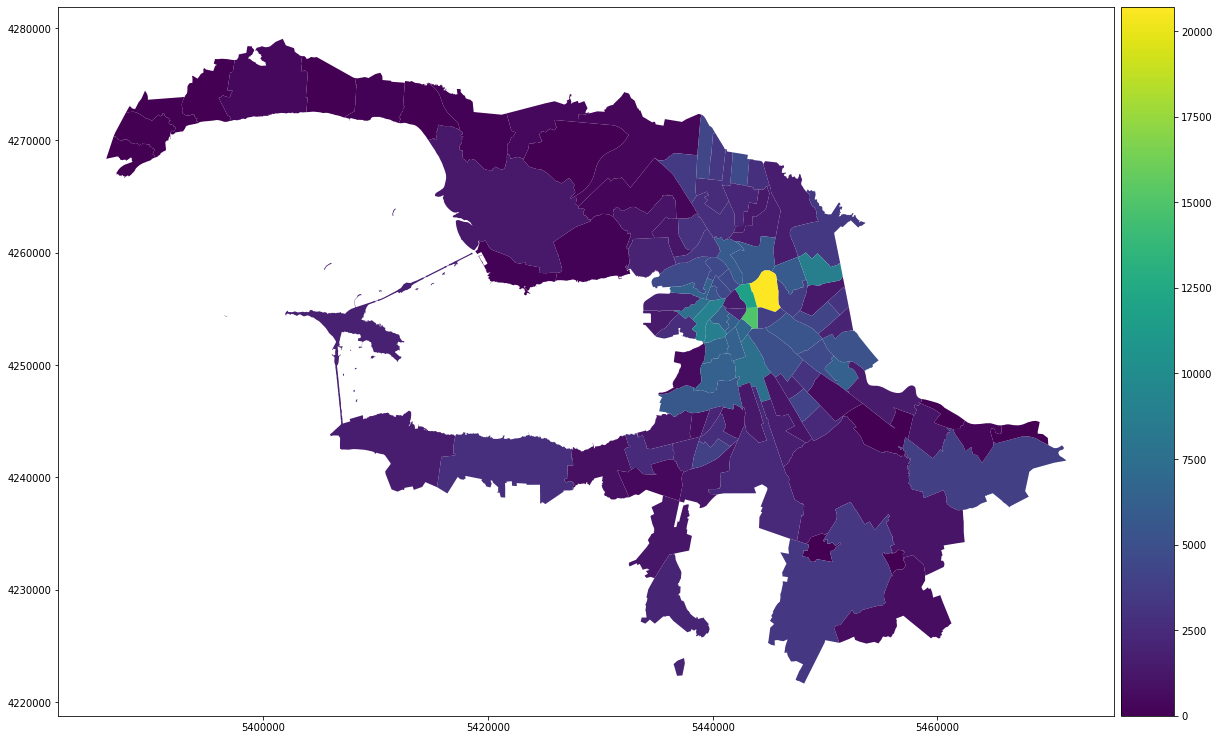

In [18]:
# абсолютное число коммунальных комнат
fig, ax = plt.subplots(1, 1, figsize=(20, 30))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
pop_sum.plot('comm_room_sum', ax=ax, legend=True, cax=cax)

In [58]:
def plot_grid(df, grid, points, col, overlay=None):     

    gdf = gpd.GeoDataFrame(df.join(points), geometry='geometry', crs={'init': 'epsg:4326'})
    df = gpd.sjoin(grid, gdf, op='contains')
    
    df = df.groupby('FID').sum()

    df = grid.join(df)
    df = gpd.GeoDataFrame(df, geometry='geometry', crs={'init': 'epsg:4326'})
    df = df.to_crs(epsg=3035)
    # выводим карту, регулируем размер легенды
    fig, ax = plt.subplots(1, 1, figsize=(80, 120))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%")

    df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
    df['coords'] = [list(coords[0]) for coords in df['coords']]

    df[(df[col].notna())].plot(column=col, ax=ax, 
                                                    cmap='plasma',
                                                   edgecolor='k', legend=False)

    for idx, row in df[(df[col].notna())].iterrows():
        try:
            ax.annotate(s=str(int(row[col])), xy=(row['coords'][0], row['coords'][1]), 
                        verticalalignment='center',
                         horizontalalignment='center', fontsize=8,
                         clip_on=True)
        except Exception:
            pass
    if overlay is not None:   
        overlay = overlay.to_crs(epsg=3035)
        overlay.plot(facecolor=(0,0,0,0), edgecolor='k', ax=ax)
    
    plt.show()

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326', 'no_defs': True} != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_fr

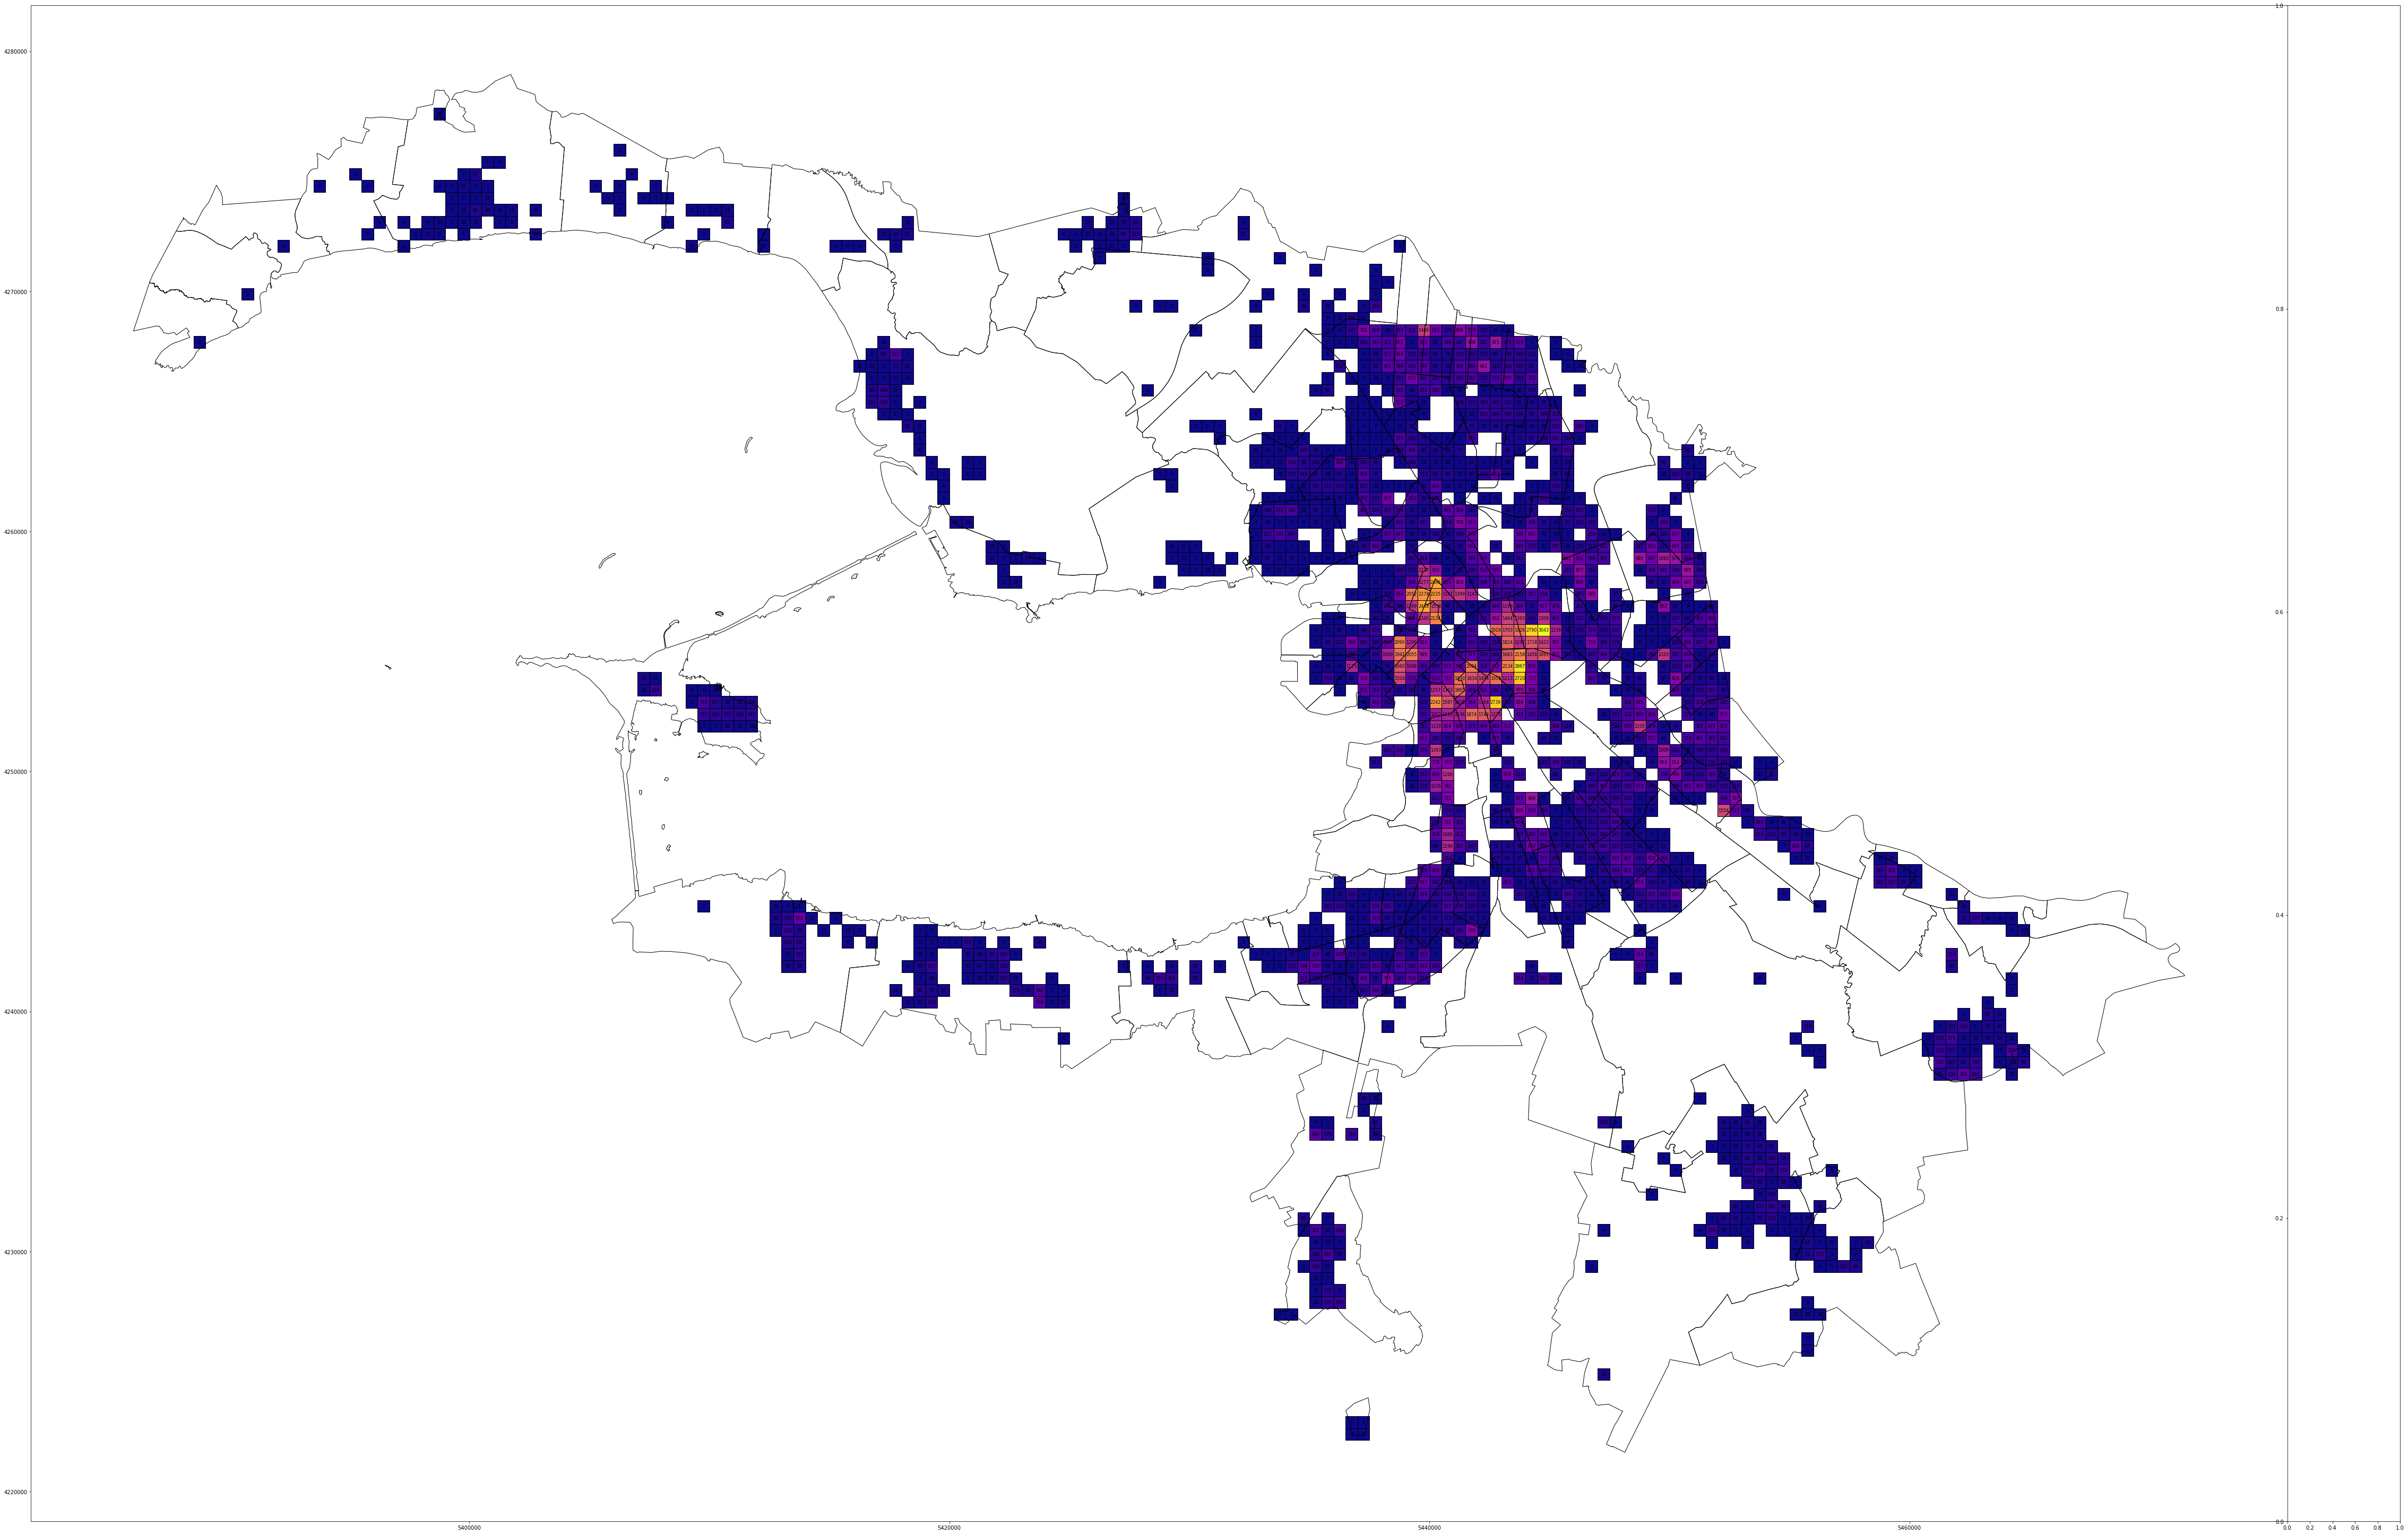

In [59]:
df = population[['comm_room_sum',]]
grid = gpd.read_file('shapes/grid500/grid500.shp', encoding='utf-8')
grid.crs
grid = grid.to_crs(epsg=4326)
col = 'comm_room_sum'

plot_grid(df, grid, points,  col, municipalities)

__Комнат частных квартир на одного жильца__

Здесь стоит обратить внимание на тот факт, что в некоторых муниципальных образованиях число многоквартирных домов не превышает десятка. Например, в Курортном районе МО Смолячково и Молодежное имеют всего по одному дому. Из-за этого картина для некоторых периферийных МО сильно искажена.

In [20]:
population[population['name'] == 'Смолячково'].sort_values(by='data_livingarea')

name                             coords  \
41  Смолячково  (29.477589672160637, 60.18839255)   

                                             geometry  index_right  \
41  POLYGON ((29.43890 60.17643, 29.43959 60.17672...        12853   

    data_livingarea  data_residents  comm_room_sum  flat_room_sum  
41             77.8             2.0            NaN            4.0

In [21]:
population[population['name'] == 'Молодёжное'].sort_values(by='data_livingarea')

name                            coords  \
40  Молодёжное  (29.507602972550156, 60.2004509)   

                                             geometry  index_right  \
40  POLYGON ((29.45195 60.20537, 29.45554 60.20755...         5611   

    data_livingarea  data_residents  comm_room_sum  flat_room_sum  
40             73.9             8.0            NaN            2.0

In [22]:
population[population['name'] == 'Сапёрный'].sort_values(by='data_livingarea')

Empty GeoDataFrame
Columns: [name, coords, geometry, index_right, data_livingarea, data_residents, comm_room_sum, flat_room_sum]
Index: []

Построим карту по МО. Старые районы имеют более плотное расселение. В МО Лахта плотность заметно ниже. Предположительно это связано с тем, что большая часть квартир сосредоточена в элитных и нераспроданных до конца ЖК.

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


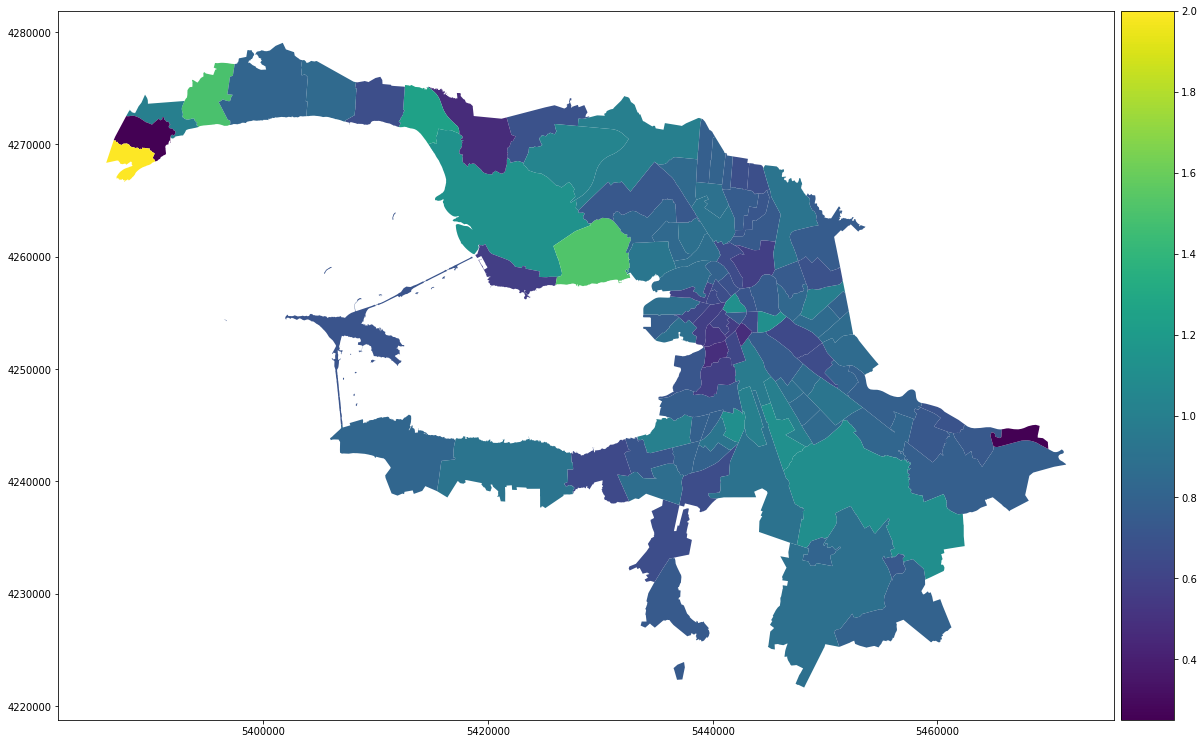

In [19]:
pop_sum = population.groupby('name').sum()
pop_sum['flat_room_density'] = pop_sum['flat_room_sum'] / pop_sum['data_residents']

pop_sum = municipalities.join(pop_sum, on='name')
pop_sum = gpd.GeoDataFrame(pop_sum, geometry='geometry', crs={'init': 'epsg:4326'})
pop_sum = pop_sum.to_crs(epsg=3035)

fig, ax = plt.subplots(1, 1, figsize=(20, 30))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
pop_sum.plot('flat_room_density', ax=ax, legend=True, cax=cax)

__Период возведения__

Перейдем к характеристикам самих зданий. Начнем с периода возведения. Видим концентрическое разрастание города, районы массового возведения жилья при Хрущеве и Брежневе, приуроченность нового жилья сталинского периода к промышленным предприятиям (расположены в сером поясе).

In [78]:
years = points.join(pd.DataFrame(pd.to_numeric(data['data_buildingdate'], errors='coerce')).dropna(), how='inner')
years = gpd.GeoDataFrame(years, geometry='geometry', crs={'init': 'epsg:4326'})

In [93]:
def periodisation(year):
    year = int(year)
    if year < 1917:
        return 'до 1917'
    elif year < 1953:
        return 'Ленин, Сталин' 
    elif year < 1964:
        return 'Хрущев'
    elif year < 1982:
        return 'Брежнев'
    elif year < 1991:
        return 'Андропов, Черненко, Горбачев'
    else:
        return 'Современная Россия'

In [94]:
years['periodisation'] = years['data_buildingdate'].map(periodisation)

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


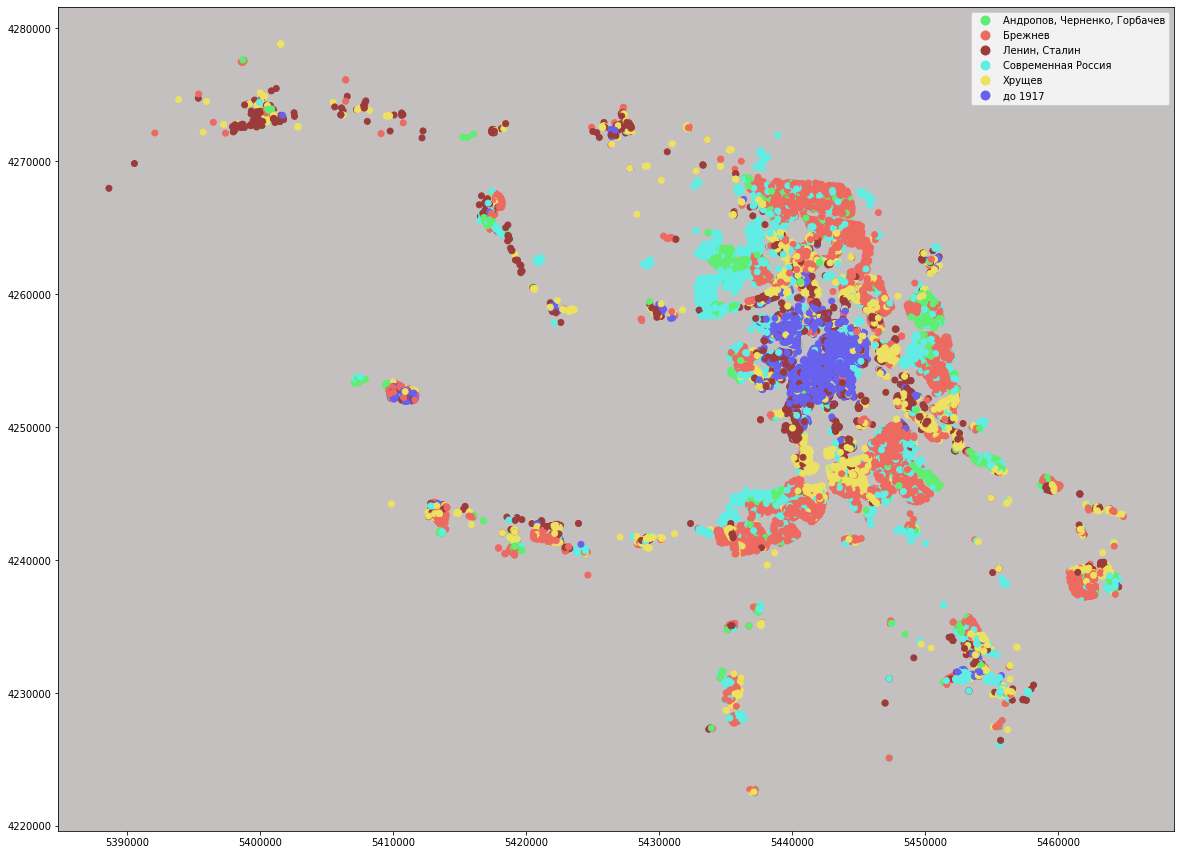

In [104]:
colors = ListedColormap(['#61ed71', '#ed6a61', '#9c3b3b', '#61ede4', '#ede161', '#6861ed'])
years = years.to_crs(epsg=3035)
fig, ax = plt.subplots(1, 1, figsize=(20, 30))
ax.set_facecolor('#c4c0c0')
years.plot(column='periodisation', cmap=colors, ax=ax, legend=True)

__Ремонты__

Подсчитаем количество проведенных работ по квадратам. Красными крестиками нанесены аварийные здания. Активнее всего ремонтируется Петроградская сторона.

In [163]:
repair = pd.read_csv('data/repairs.csv', index_col='building')
reconstruction = pd.read_csv('data/reconstruction.csv', index_col='Unnamed: 0')
failure = pd.read_csv('data/failure.csv', index_col='Unnamed: 0')

In [164]:
repair = repair.groupby(by='building').count()
repair  = points.join(repair, how='inner')
repair  = gpd.GeoDataFrame(repair , geometry='geometry', crs={'init': 'epsg:4326'})
repair = gpd.sjoin(grid, repair, op='contains')

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326', 'no_defs': True} != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [165]:
failure = points.join(failure, how='inner')
failure  = gpd.GeoDataFrame(failure, geometry='geometry', crs={'init': 'epsg:4326'})
failure = failure.to_crs(epsg=3035)

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


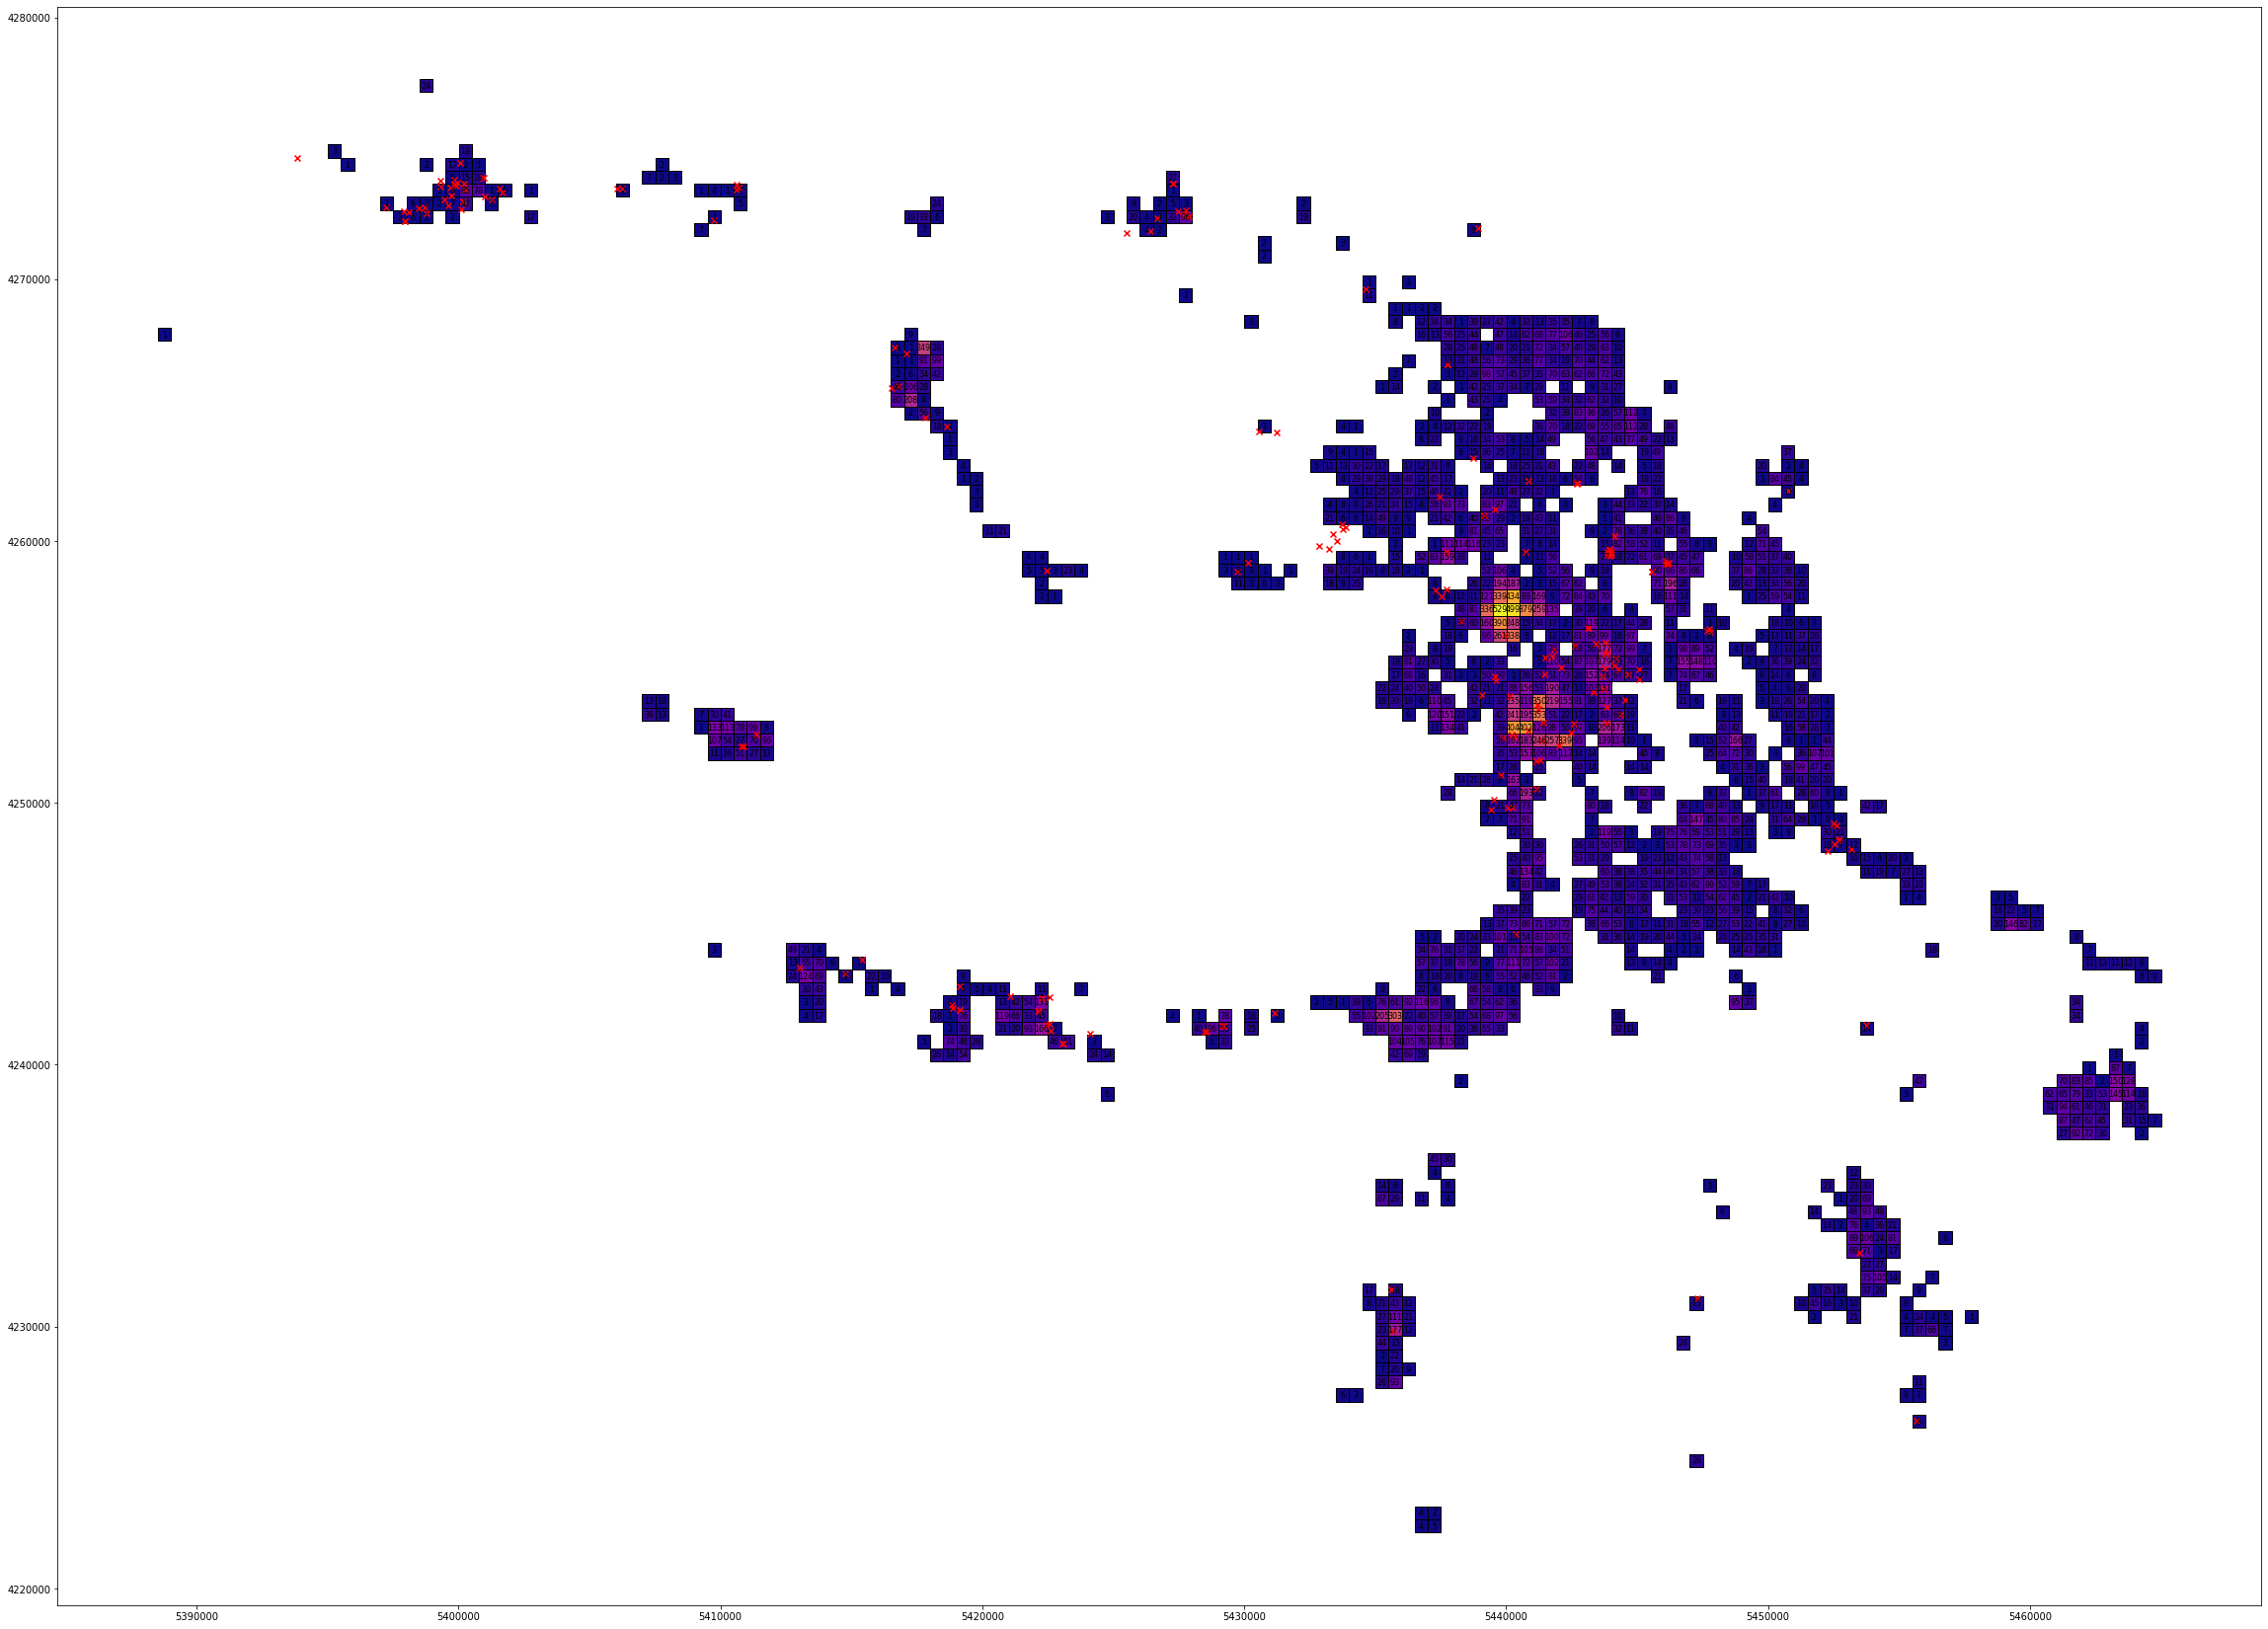

In [166]:
repair = repair.groupby('FID').sum()
# repair = repair.drop('geometry', axis=1)
# storeys_count = population.groupby('FID').count()
# storeys_sum['avg_storeys'] = storeys_sum['data_storeys'] / storeys_count['data_storeys']
repair = grid.join(repair)
repair = gpd.GeoDataFrame(repair, geometry='geometry', crs={'init': 'epsg:4326'})
repair = repair.to_crs(epsg=3035)
# выводим карту, регулируем размер легенды
fig, ax = plt.subplots(1, 1, figsize=(40, 60))

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%")

repair['coords'] = repair['geometry'].apply(lambda x: x.representative_point().coords[:])
repair['coords'] = [list(coords[0]) for coords in repair['coords']]

repair[(repair['job'].notna())].plot(column='job', ax=ax, 
                                                cmap='plasma',
                                               edgecolor='k', legend=False)

for idx, row in repair[(repair['job'].notna())].iterrows():
    try:
        ax.annotate(s=str(int(row['job'])), xy=(row['coords'][0], row['coords'][1]), 
                    verticalalignment='center',
                     horizontalalignment='center', fontsize=8,
                     clip_on=True)
    except Exception:
        pass
    
failure.plot(marker='x', color='red', ax=ax)

plt.show()

__Газификация__

Отдельно выделены зеленым негазифицированные районы. Совпадают с районами новой затройки: с повышением этажности подведение газа стало треовать дополнительного оборудования, изменились представления о безопасности.

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326', 'no_defs': True} != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/geopandas/plotting.py:494: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


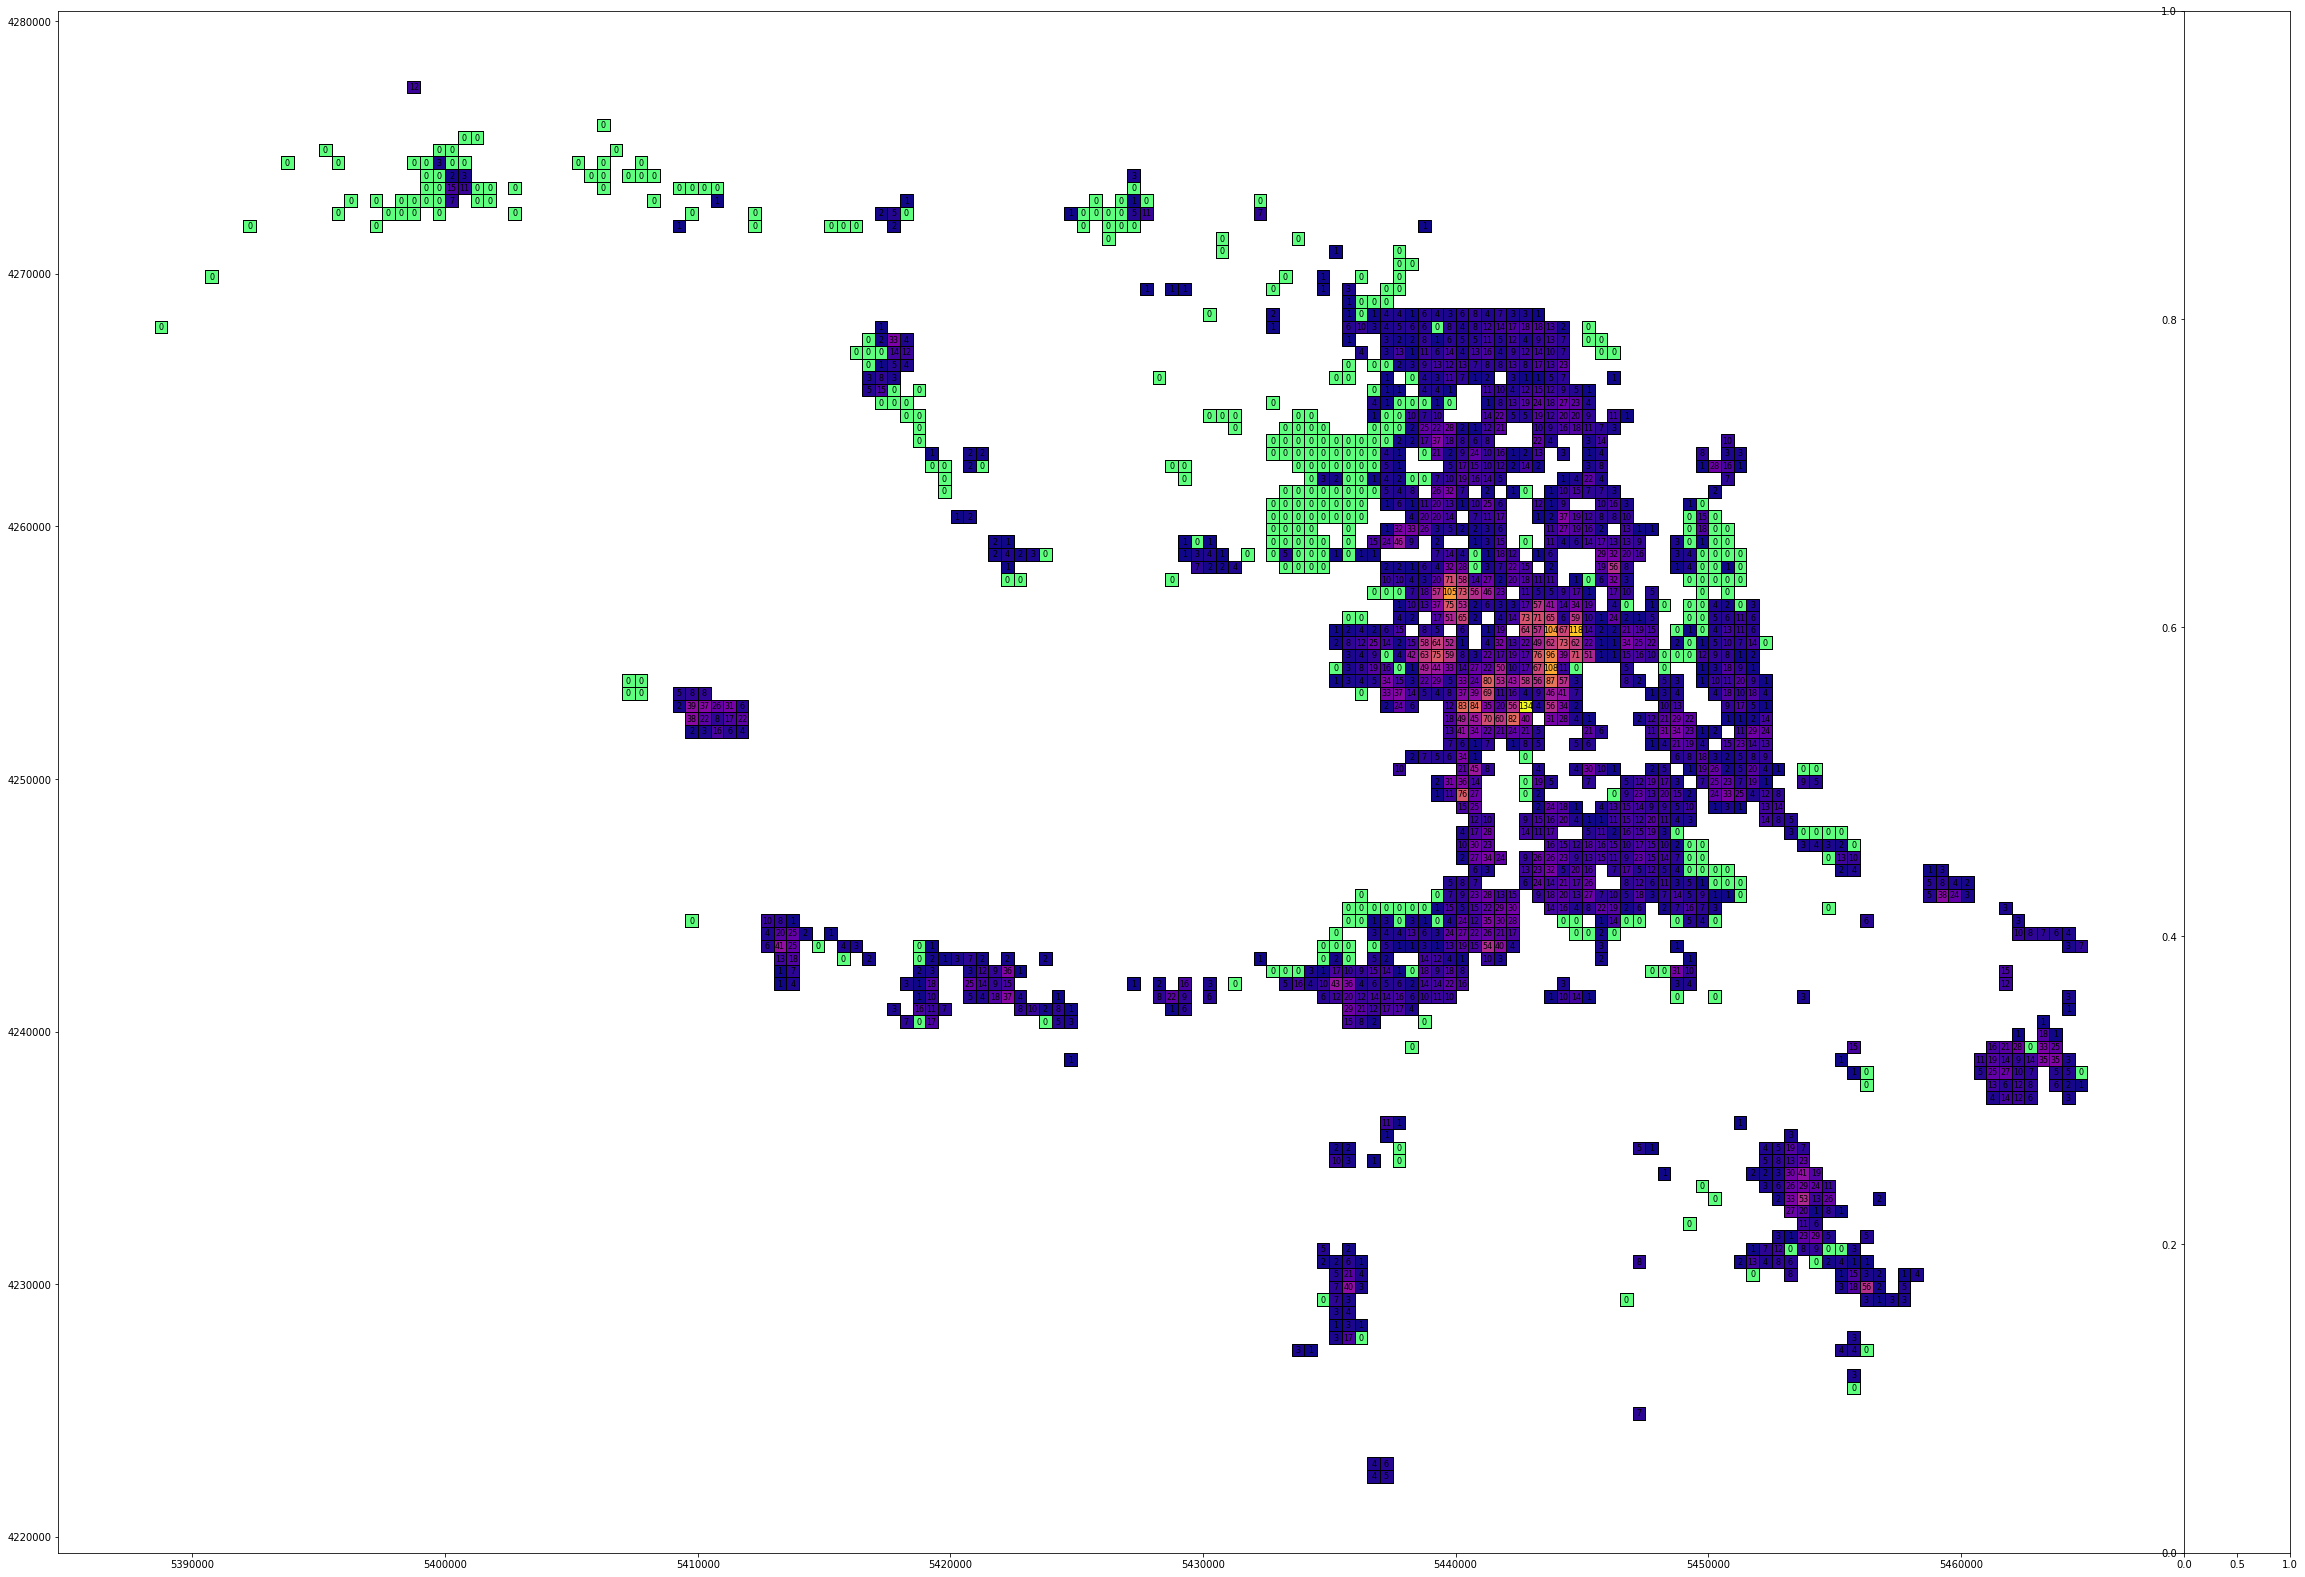

In [176]:
# отбираем интересующие данные из датасета
gas = data[['eng_gascentral', 'eng_gasnoncentral']]
gas = gpd.GeoDataFrame(gas.join(points), geometry='geometry', crs={'init': 'epsg:4326'})
gas = gpd.sjoin(grid, gas, op='contains')

gas = gas.groupby('FID').sum()
# storeys_count = population.groupby('FID').count()
# storeys_sum['avg_storeys'] = storeys_sum['data_storeys'] / storeys_count['data_storeys']

gas = grid.join(gas)
gas = gpd.GeoDataFrame(gas, geometry='geometry', crs={'init': 'epsg:4326'})
gas = gas.to_crs(epsg=3035)
# выводим карту, регулируем размер легенды
fig, ax = plt.subplots(1, 1, figsize=(40, 60))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%")

gas['coords'] = gas['geometry'].apply(lambda x: x.representative_point().coords[:])
gas['coords'] = [list(coords[0]) for coords in gas['coords']]

gas[(gas['eng_gascentral'].notna())].plot(column='eng_gascentral', ax=ax, 
                                                cmap='plasma',
                                               edgecolor='k', legend=False)
gas[(gas['eng_gascentral'].notna()) & (gas['eng_gascentral'] == 0)].plot(column='eng_gascentral', ax=ax, 
                                                 color='#5eff7e',
                                               edgecolor='k', legend=False)

for idx, row in gas[(gas['eng_gascentral'].notna())].iterrows():
    try:
        ax.annotate(s=str(int(row['eng_gascentral'])), xy=(row['coords'][0], row['coords'][1]), 
                    verticalalignment='center',
                     horizontalalignment='center', fontsize=8,
                     clip_on=True)
    except Exception:
        pass
plt.show()

__Этажность__

Этажность застройки ожидаемо выше для более новых зданий.

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326', 'no_defs': True} != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


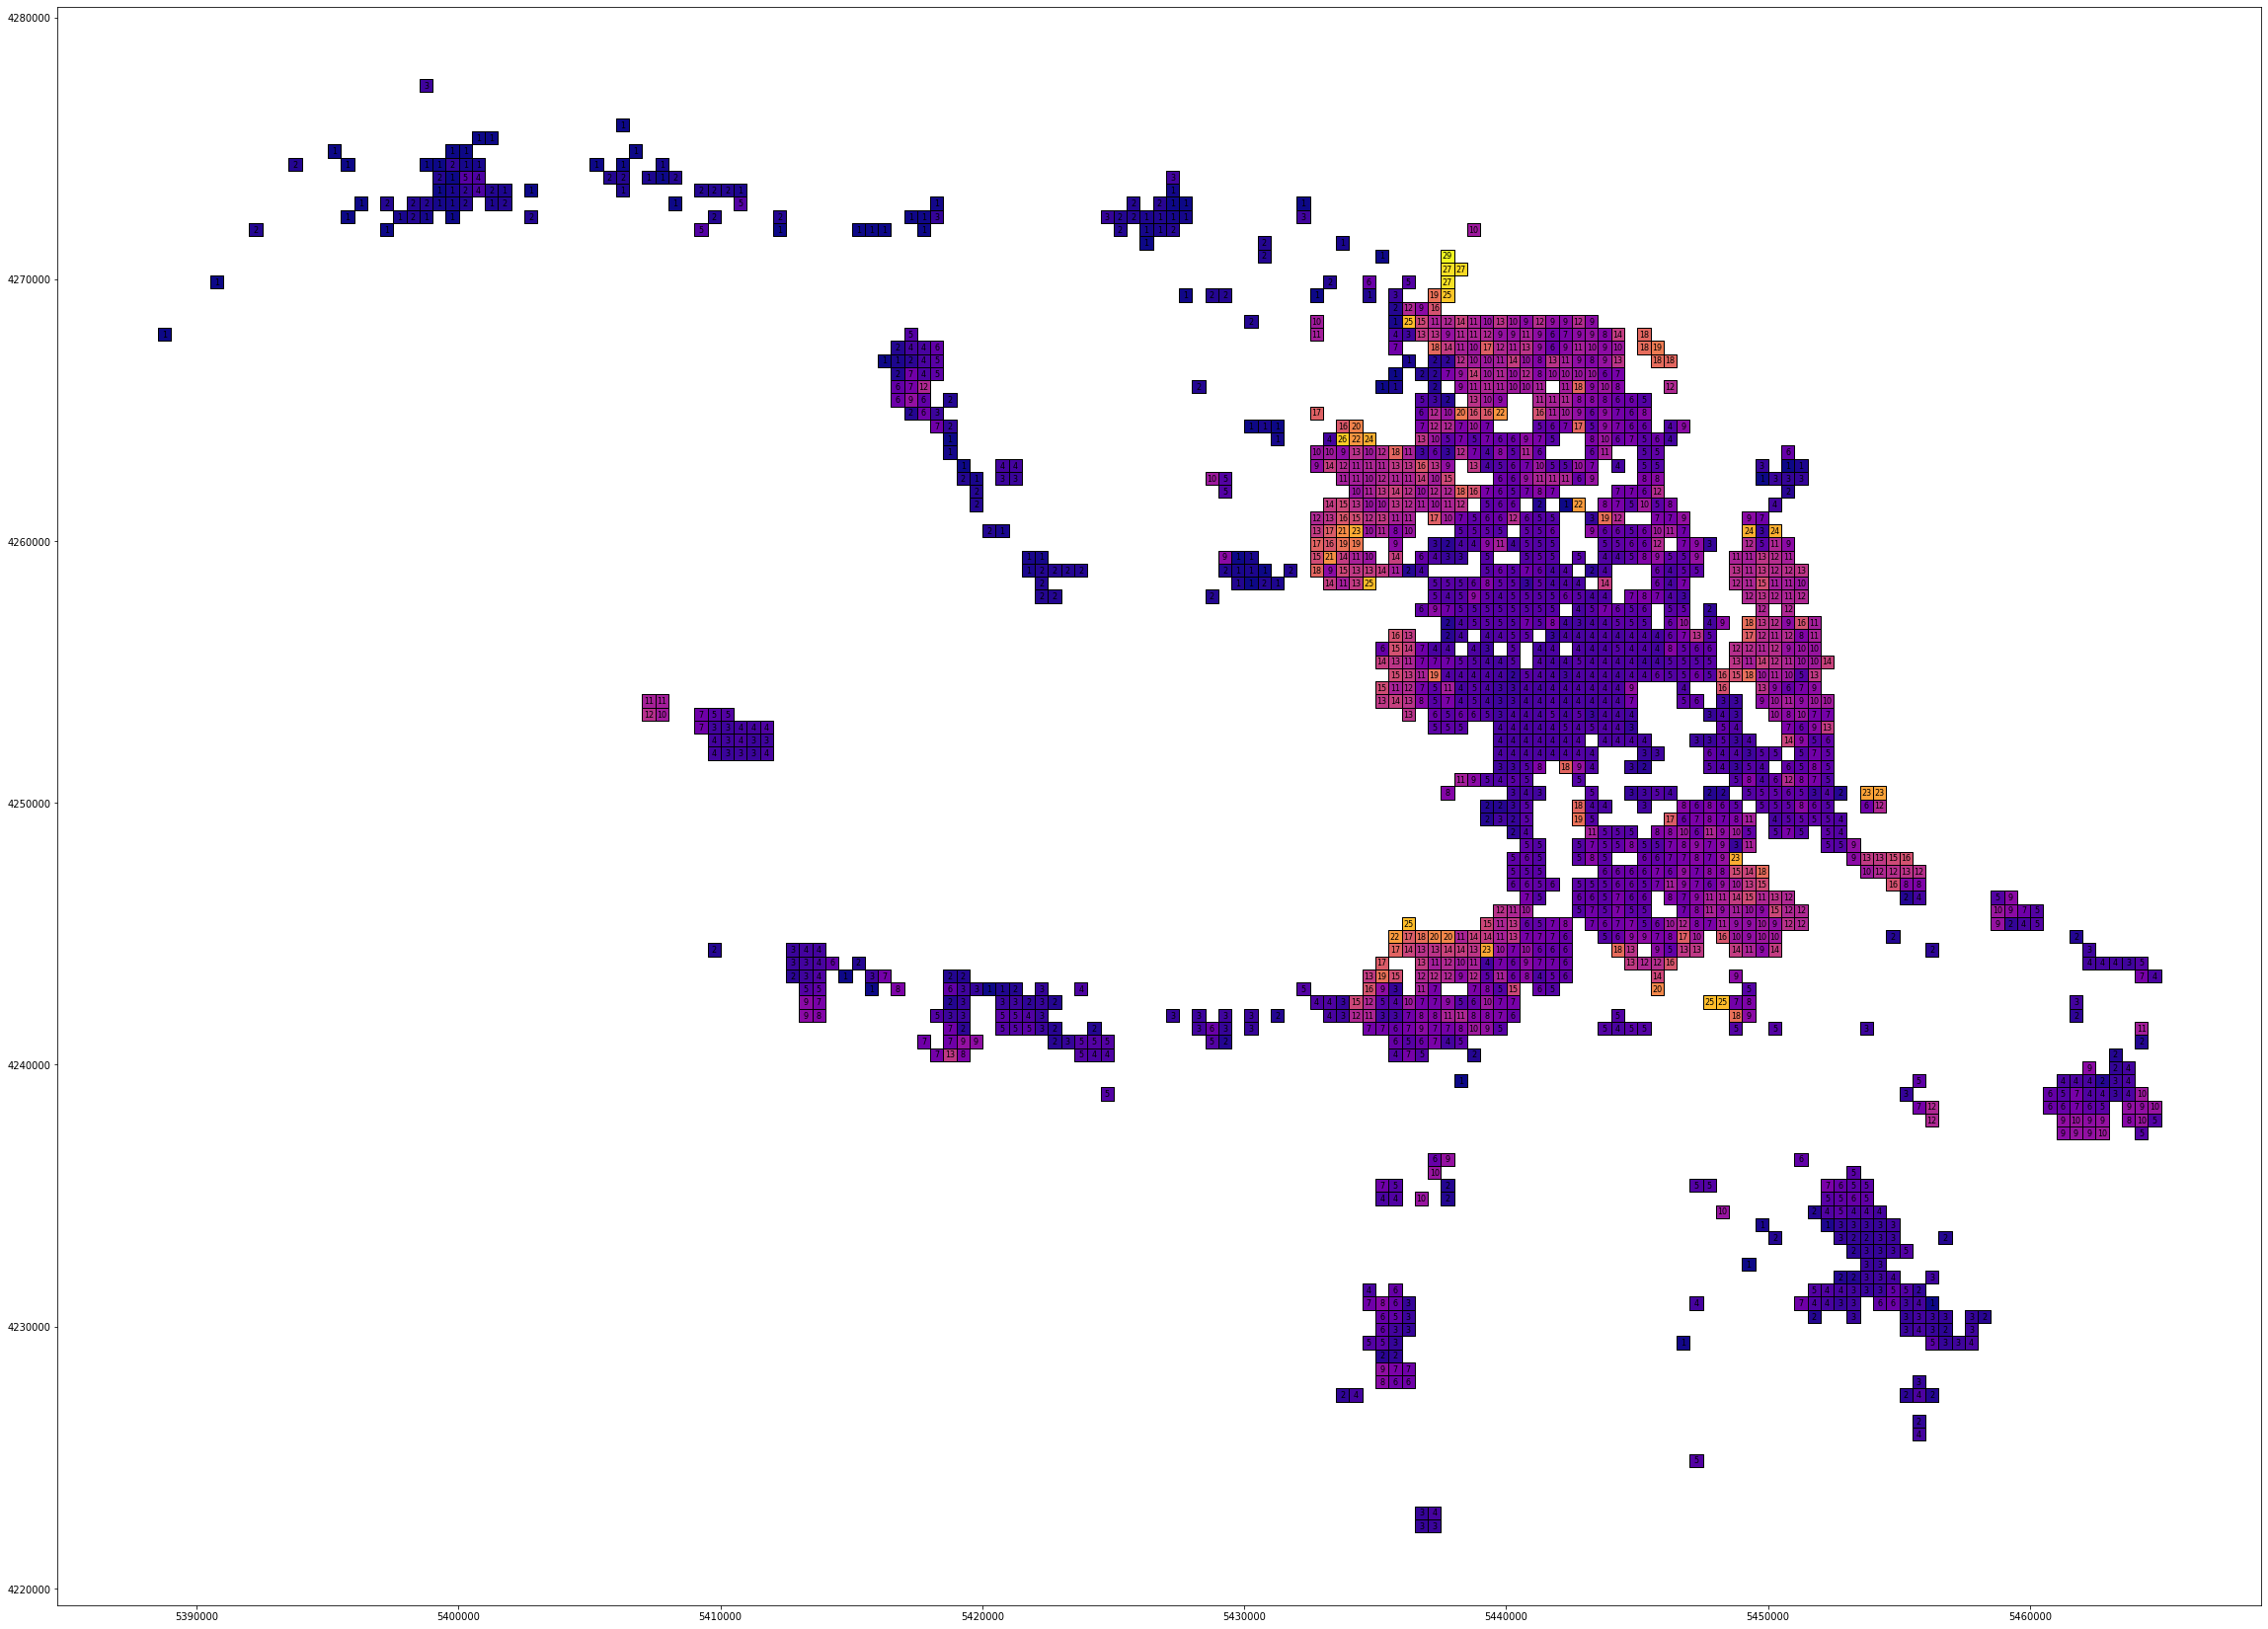

In [175]:
# отбираем интересующие данные из датасета
population = data[['data_storeys',]]
population = gpd.GeoDataFrame(population.join(points), geometry='geometry', crs={'init': 'epsg:4326'})

# делаем spatial join: муниципальные образования + дома
population = gpd.sjoin(grid, population, op='contains')

storeys_sum = population.groupby('FID').sum()
storeys_count = population.groupby('FID').count()
storeys_sum['avg_storeys'] = storeys_sum['data_storeys'] / storeys_count['data_storeys']

storeys_sum = grid.join(storeys_sum)
storeys_sum = gpd.GeoDataFrame(storeys_sum, geometry='geometry', crs={'init': 'epsg:4326'})
storeys_sum = storeys_sum.to_crs(epsg=3035)
# выводим карту, регулируем размер легенды
fig, ax = plt.subplots(1, 1, figsize=(40, 60))
# ax.set_facecolor('#202623')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%")

storeys_sum['coords'] = storeys_sum['geometry'].apply(lambda x: x.representative_point().coords[:])
storeys_sum['coords'] = [list(coords[0]) for coords in storeys_sum['coords']]

storeys_sum[(storeys_sum['avg_storeys'].notna())].plot(column='avg_storeys', ax=ax, 
                                                cmap='plasma',
                                               edgecolor='k', legend=False)

for idx, row in storeys_sum[(storeys_sum['avg_storeys'].notna())].iterrows():
    try:
        ax.annotate(s=str(int(row['avg_storeys'])), xy=(row['coords'][0], row['coords'][1]), 
                    verticalalignment='center',
                     horizontalalignment='center', fontsize=8,
                     clip_on=True)
    except Exception:
        pass
plt.show()

__Серый пояс__

/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/gustav/Projects/StPHousing/env/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


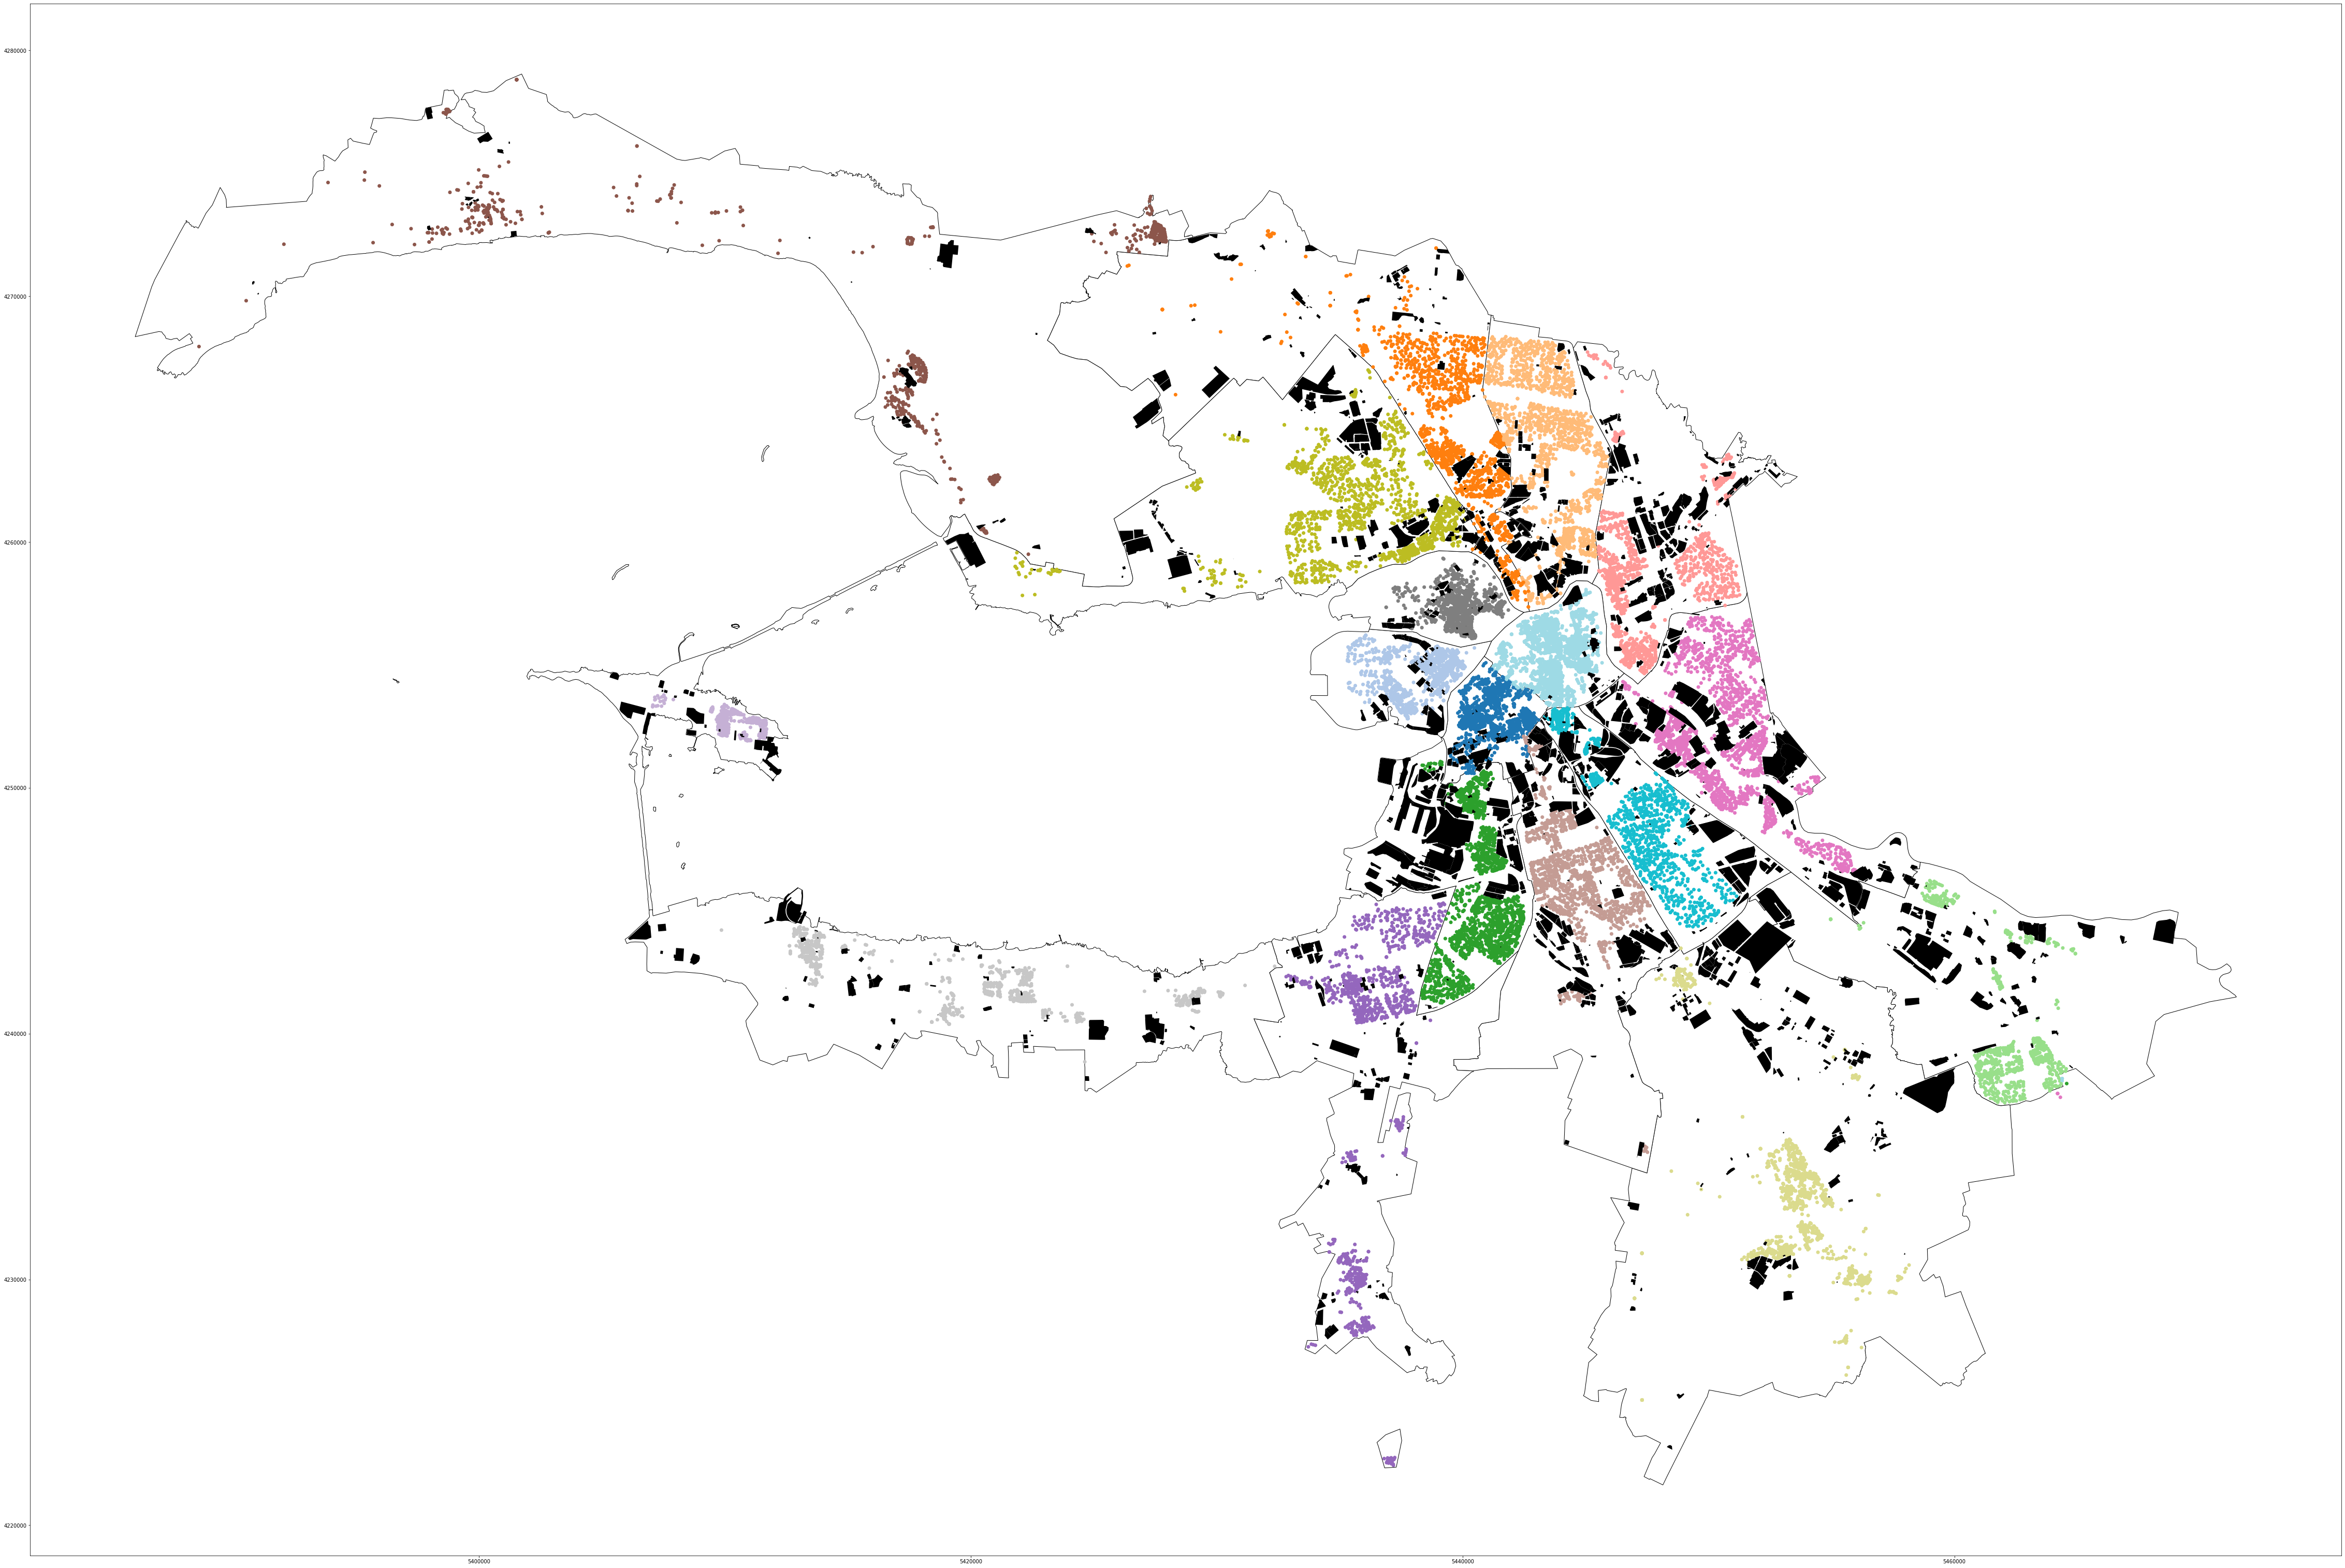

In [18]:
districts = gpd.read_file('shapes/districts/districts.shp', encoding='utf-8', crs={'init': 'epsg:4326'})
landuse = gpd.read_file('shapes/landuse_polygons/landuse_polygons.shp', crs={'init': 'epsg:4326'})
landuse = landuse.to_crs(epsg=3035)
districts = districts.to_crs(epsg=3035)
houses = gpd.GeoDataFrame(data[['addr_district', ]].join(points), geometry='geometry', crs={'init': 'epsg:4326'})
houses = houses.dropna().to_crs(epsg=3035)
fig, ax = plt.subplots(figsize=(80, 80))
districts.plot(ax=ax, color='white', edgecolor='k')
houses.plot(column='addr_district', cmap='tab20', ax=ax)
landuse[landuse['LANDUSE'] == 'industrial'].plot(facecolor="k", ax=ax)